# Binary Classification with PyTorch Transfer Learning (Resnet50)

Import classes

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

import torch
from torchvision import transforms, models
from torchvision.transforms import v2
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

from torch.utils.tensorboard import SummaryWriter
from skimage import io, exposure, color, img_as_float32
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


Like our last example  lets load our images from the folders and convert our labels to integers for classification

In [2]:
def load_images_from_folder(folder_path):
    
    images = []
    labels = []
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                # Read image and convert to float32 to handle UInt16 data
                img = io.imread(img_path)
                images.append(img)
                labels.append(class_name)

    return np.array(images), np.array(labels)


train_path = "class_dataset/train"
test_path = "class_dataset/test"

train_images, train_labels = load_images_from_folder(train_path)
test_images, test_labels = load_images_from_folder(test_path)


# Convert string labels to 0 and 1 integers
unique_labels = np.unique(train_labels)
label_map = {label: i for i, label in enumerate(unique_labels)}
print(f"Label mapping: {label_map}")

train_labels = np.array([label_map[label] for label in train_labels])
test_labels = np.array([label_map[label] for label in test_labels])
    
    

Label mapping: {'Adenovirus': 0, 'Influenza': 1}


Next let's set up our dataset class

In [3]:
from torch.utils.data import DataLoader, Dataset

class VirusDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = torch.from_numpy(labels).float().unsqueeze(1)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

Lets swap out our existing architecture for Resnet50.  We need to:

* reset the conv1 layer to 1 input channel instead of 3 (RGB)
* modify the fully connected layer for binary classification.

In [4]:
import torch.nn as nn

# Create a ResNet50 model for binary classification
class ResNetBinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetBinaryClassifier, self).__init__()

        self.resnet = models.resnet50()
        
        # Modify the first convolutional layer to accept grayscale input (1 channel)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the final fully connected layer for binary classification
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 1)  # Binary classification
    
    def forward(self, x):
        return self.resnet(x)


Time to build our training loop

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, tensorboard_writer=None):
    
    # send model to cpu or gpu
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            # Ensure outputs and labels have the same shape for BCEWithLogitsLoss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        # Calculate epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        val_preds = np.array(val_preds).flatten()
        val_labels = np.array(val_labels).flatten()
        
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, zero_division=0)
        val_recall = recall_score(val_labels, val_preds, zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, zero_division=0)
        
        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Val. Loss: {epoch_loss:.4f}, Val. Accuracy: {val_accuracy:.4f}")
        print(f"Val. Precision: {val_precision:.4f}, Val. Recall: {val_recall:.4f}, Val. F1-Score: {val_f1:.4f}")
        
        # Log to TensorBoard
        if tensorboard_writer:
            tensorboard_writer.add_scalar('Loss/train', epoch_loss, epoch)
            tensorboard_writer.add_scalar('Metrics/accuracy', val_accuracy, epoch)
            tensorboard_writer.add_scalar('Metrics/precision', val_precision, epoch)
            tensorboard_writer.add_scalar('Metrics/recall', val_recall, epoch)
            tensorboard_writer.add_scalar('Metrics/f1', val_f1, epoch)
    
    return model

Let's apply augmentations to our images with v2.  These apply to every image

Resnet, like other pretrained models, has requirements for the size and normalization for the images.

In [6]:
from torchvision.transforms import v2

# ResNet expects images to be at least 224x224, so we need to resize
# Define transforms for ResNet - adapted for grayscale images
train_transform = v2.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),  # Resize to match ResNet input
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.485], std=[0.229])  # ResNet normalization for grayscale
])

test_transform = v2.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),  # Resize to match ResNet input
    transforms.Normalize(mean=[0.485], std=[0.229])  # ResNet normalization for grayscale
])


We are ready now to initalize our datasets

In [7]:
# Create datasets
train_dataset = VirusDataset(train_images, train_labels, transform=train_transform)
test_dataset = VirusDataset(test_images, test_labels, transform=test_transform)

# Split training data into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=0)

test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False, 
                         num_workers=0)

Initilize our model, loss function and optimizer.  Send model to GPU

In [8]:

model = ResNetBinaryClassifier(pretrained=True)

for name, param in model.resnet.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.0001) #use a lower learning rate for transfer learning

model.to(device)

ResNetBinaryClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Set up Tensorboard

In [9]:
# Set up TensorBoard
run_id = datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = f"runs/virus_resnet50_experiment_{run_id}"
tensorboard_writer = SummaryWriter(log_dir)


Time to train our model!

In [ ]:
model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    tensorboard_writer=tensorboard_writer
)

# Close TensorBoard writer
tensorboard_writer.close()

Now let's use our model on the test data

In [11]:
print("Testing model...")
model.eval()
test_preds = []
test_labels_list = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        
        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

# Calculate and print test metrics
test_preds = np.array(test_preds).flatten()
test_labels_list = np.array(test_labels_list).flatten()

print("\nTest Results:")
print(classification_report(test_labels_list, test_preds))

Testing model...


Testing: 100%|██████████| 16/16 [00:00<00:00, 16.23it/s]


Test Results:
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        86
         1.0       0.96      1.00      0.98       170

    accuracy                           0.97       256
   macro avg       0.98      0.95      0.96       256
weighted avg       0.97      0.97      0.97       256



Let's take a random sample from our test set and perform a prediction.  Then we will

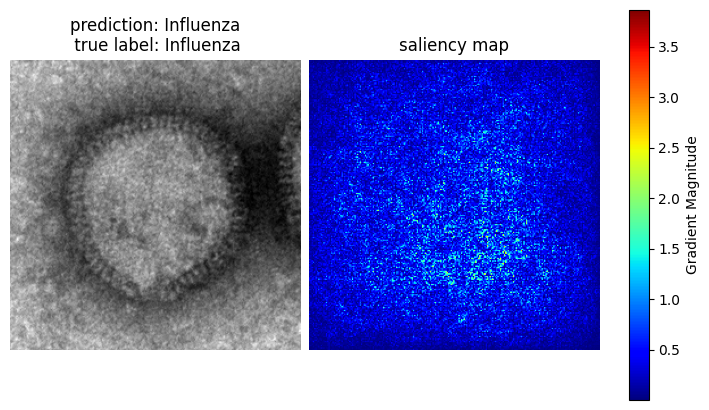

In [14]:
# Randomly select one test image
test_data = list(zip(test_images, test_labels))
random_sample = random.choice(test_data)

# Unpack the randomly selected sample
img, true_label = random_sample

# reverse map to find label text
reverse_map = {v: k for k, v in label_map.items()}
true_label = reverse_map[true_label]

# Preprocess the image for classification
img_t = test_transform(img).unsqueeze(0).to(device)


# Generate prediction
model.eval()

# First forward pass - without gradients for prediction
with torch.no_grad():
    output = model(img_t)
    prob = torch.sigmoid(output).item()
    pred_class = 1 if prob > 0.5 else 0
    pred_label = 'Influenza' if pred_class == 1 else 'Adenovirus'


# Set up for saliency map calculation
img_t.requires_grad_()

# Forward pass
output = model(img_t)
output[0, output.argmax()].backward()

# Create saliency map
saliency_map = img_t.grad.data.abs().squeeze().cpu().numpy()



fig, ax = plt.subplots(1, 2, figsize=(7, 4), constrained_layout=True)
ax[0].imshow(img, cmap='gray')
ax[0].set_title(f"prediction: {pred_label}\n true label: {true_label}")
ax[0].axis('off')

# Plot saliency map
saliency_plot = ax[1].imshow(saliency_map, cmap='jet')
ax[1].set_title("saliency map")
ax[1].axis('off')

# Add colorbar to the right of the saliency map
plt.colorbar(saliency_plot, ax=ax, label='Gradient Magnitude')

plt.show()